#Airbus fuel leak detection with Autoencoders

<img 
    src="http://www.occar.int/sites/default/files/styles/hero_image/public/images/programme-page/A400M.jpg?itok=KEPatgWr" width="1000" height="250" align="center"/>

## 1) Importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
from matplotlib import pyplot as plt, dates
import seaborn as sns
from datetime import datetime
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

## 2) Loading data

The dataset contains simulated leaks of 5kg/s, 1kg/s and 0.5kg/s.

In [ ]:
final = pd.read_csv("/content/drive/MyDrive/capstone/dataset_autoencoder_fakeleaks_resampled.csv", sep=',')

In [ ]:
dl = final.copy()
dl = dl.dropna()

## 3) Feature selection

We decided to combine all the fuel used and all the fuel tank quantities into 2 features to simplify our model.

In [ ]:
def add_features(dataset):
  dataset['TOTAL_FUEL_USED'] = dataset['FUEL_USED_1'] +  dataset['FUEL_USED_2'] +  dataset['FUEL_USED_3'] +  dataset['FUEL_USED_4']
  dataset['TOTAL_FUEL_QTY'] = dataset['VALUE_FUEL_QTY_CT'] + dataset['VALUE_FUEL_QTY_FT1'] + dataset['VALUE_FUEL_QTY_FT2'] + dataset['VALUE_FUEL_QTY_FT3'] + dataset['VALUE_FUEL_QTY_FT4'] + dataset['VALUE_FUEL_QTY_LXT'] + dataset['VALUE_FUEL_QTY_RXT']
  return dataset 

def drop(dataset):
    dataset = dataset.drop(['FUEL_USED_1','FUEL_USED_2','FUEL_USED_3','FUEL_USED_4','VALUE_FUEL_QTY_CT', 'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3','VALUE_FUEL_QTY_FT4', 'VALUE_FUEL_QTY_LXT', 'VALUE_FUEL_QTY_RXT'], 1)
    return dataset

In [ ]:
dl = add_features(dl)
dl = drop(dl)

In [ ]:
dl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43489 entries, 0 to 43488
Data columns (total 14 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   UTC_TIME                            43489 non-null  object 
 1   ORIGINAL_INDEX                      43489 non-null  float64
 2   FW_GEO_ALTITUDE                     43489 non-null  float64
 3   DELTA_TOTAL_FUEL_USED               43489 non-null  float64
 4   VALUE_FOB                           43489 non-null  float64
 5   VALUE_FOB_FROM_CONSUMPTION          43489 non-null  float64
 6   VALUE_FOB_vs_FROM_CONSUMPTION       43489 non-null  float64
 7   FOB_FITLINE                         43489 non-null  float64
 8   FOB_vs_FITLINE                      43489 non-null  float64
 9   FOB_vs_FITLINE_OVER_FOB             43489 non-null  float64
 10  DIFF_VALUE_FOB_vs_FROM_CONSUMPTION  43489 non-null  float64
 11  LABEL                               43489

In [ ]:
dl = dl.drop(['ORIGINAL_INDEX', 'UTC_TIME', 'FW_GEO_ALTITUDE'], axis = 1)

In [ ]:
move_column1 = dl.pop('LABEL')

dl.insert(10, 'LABEL', move_column1)

In [ ]:
dl['LABEL'].replace([1,0],[0,1],inplace=True)

In [ ]:
dl['LABEL'].value_counts()

1.0    24596
0.0    18893
Name: LABEL, dtype: int64

In [ ]:
raw_data = dl.values

## 4) Train/Test Split

In [ ]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

In [ ]:
print(train_data.shape)
print(train_labels.shape)

(34791, 10)
(34791,)


In [ ]:
np.mean(train_labels)

0.5664108533816217

## 4) Normalization

In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float64)
test_data = tf.cast(test_data, tf.float64)

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [ ]:
print(labels.shape)
print(data.shape)
print('')
print(train_labels.shape)
print(test_labels.shape)
print('')
print(normal_train_data.shape)
print(normal_test_data.shape)
print('')
print(anomalous_train_data.shape)
print(anomalous_test_data.shape)

(43489,)
(43489, 10)

(34791,)
(8698,)

(19706, 10)
(4890, 10)

(15085, 10)
(3808, 10)


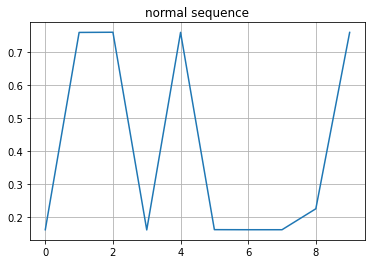

In [ ]:
plt.grid()
plt.plot(np.arange(10), normal_train_data[0])
plt.title("normal sequence")
plt.show()

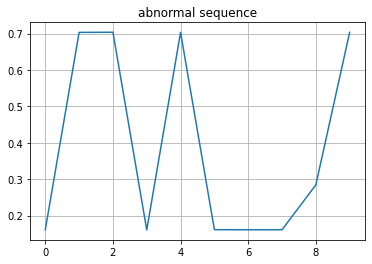

In [ ]:
plt.grid()
plt.plot(np.arange(10), anomalous_train_data[0])
plt.title("abnormal sequence")
plt.show()

## 5) Autoencoder Model

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([                                  
      layers.Dense(80, activation="relu"),
      layers.Dense(70, activation="relu"),
      layers.Dense(60, activation="relu"),                                  
      layers.Dense(50, activation="relu"),
      layers.Dense(40, activation="relu"),
      layers.Dense(30, activation="relu"),
      layers.Dense(20, activation="relu")])
      
    
    self.decoder = tf.keras.Sequential([ 
      layers.Dense(20, activation="relu"),                                 
      layers.Dense(30, activation="relu"),
      layers.Dense(40, activation="relu"),
      layers.Dense(50, activation= 'relu'),
      layers.Dense(60, activation= 'relu'),
      layers.Dense(70, activation= "relu"),
      layers.Dense(80, activation="relu"),
      layers.Dense(10, activation="sigmoid")
      ])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss= 'mse')

## 6) Training

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=300, 
          batch_size=100,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/300
198/198 [==============================] - 5s 13ms/step - loss: 0.0114 - val_loss: 0.0011
Epoch 2/300
198/198 [==============================] - 2s 12ms/step - loss: 7.8934e-04 - val_loss: 7.5600e-04
Epoch 3/300
198/198 [==============================] - 2s 12ms/step - loss: 5.6702e-04 - val_loss: 9.7028e-05
Epoch 4/300
198/198 [==============================] - 3s 13ms/step - loss: 2.9014e-05 - val_loss: 5.7824e-05
Epoch 5/300
198/198 [==============================] - 3s 14ms/step - loss: 1.2773e-05 - val_loss: 4.7353e-05
Epoch 6/300
198/198 [==============================] - 3s 13ms/step - loss: 8.9657e-06 - val_loss: 5.1363e-05
Epoch 7/300
198/198 [==============================] - 3s 14ms/step - loss: 7.7594e-06 - val_loss: 4.6884e-05
Epoch 8/300
198/198 [==============================] - 3s 13ms/step - loss: 9.6903e-06 - val_loss: 4.6490e-05
Epoch 9/300
198/198 [==============================] - 2s 12ms/step - loss: 7.7449e-06 - val_loss: 4.6399e-05
Epoch 10/300
198/1

In [ ]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                880       
                                                                 
 dense_1 (Dense)             (None, 70)                5670      
                                                                 
 dense_2 (Dense)             (None, 60)                4260      
                                                                 
 dense_3 (Dense)             (None, 50)                3050      
                                                                 
 dense_4 (Dense)             (None, 40)                2040      
                                                                 
 dense_5 (Dense)             (None, 30)                1230      
                                                                 
 dense_6 (Dense)             (None, 20)                6

In [ ]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 20)                420       
                                                                 
 dense_8 (Dense)             (None, 30)                630       
                                                                 
 dense_9 (Dense)             (None, 40)                1240      
                                                                 
 dense_10 (Dense)            (None, 50)                2050      
                                                                 
 dense_11 (Dense)            (None, 60)                3060      
                                                                 
 dense_12 (Dense)            (None, 70)                4270      
                                                                 
 dense_13 (Dense)            (None, 80)               

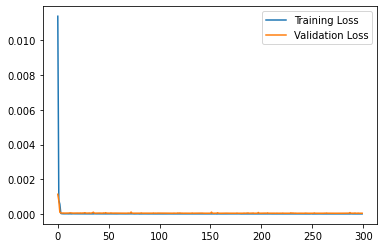

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

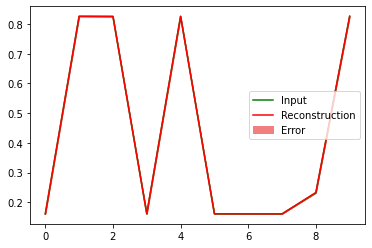

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'g')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(10), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

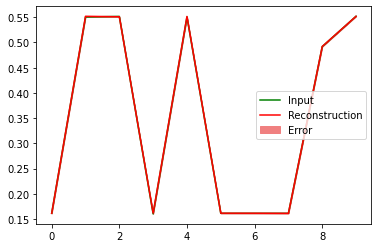

In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'g')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(10), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

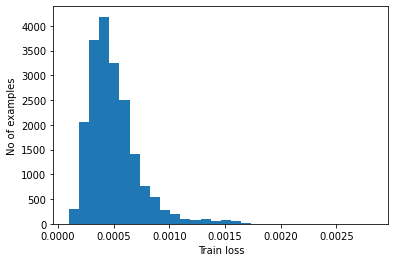

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=30)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss) 
print("Threshold: ", threshold)

Threshold:  0.0007312862784257117


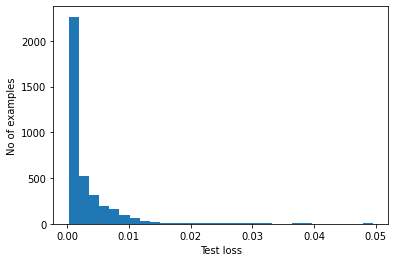

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=30)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

## 7) Results

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

Accuracy on testing data: 85.38%
Precision on testing data: 85.69%
Recall on testing data: 88.81%
F1 on testing data: 87.23%
Gini on testing data: 69.78%


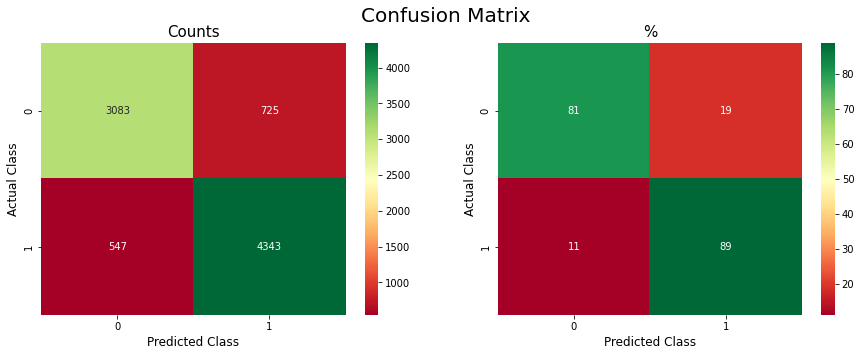

In [ ]:
preds = predict(autoencoder, test_data, threshold)

y_test = test_labels
y_test_pred = preds
acc_test = accuracy_score(y_test, y_test_pred)
prec_test = precision_score(y_test, y_test_pred)
rec_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
gini_test = 2*roc_auc_score(y_test, y_test_pred)-1


cm = confusion_matrix(y_test, y_test_pred)
cm2 = confusion_matrix(y_test, y_test_pred, normalize = 'true') 

fig, ax = plt.subplots(1,2,figsize = (15,5))
fig.suptitle("Confusion Matrix", fontsize = 20 )
sns.heatmap(cm, cmap = 'RdYlGn', annot=True, fmt='.0f',
           xticklabels = [0, 1],
           yticklabels = [0, 1],
           ax = ax[0]
           )

ax[0].set_xlabel("Predicted Class", fontsize = 12)
ax[0].set_ylabel("Actual Class", fontsize = 12)
ax[0].set_title("Counts", fontsize = 15)

sns.heatmap(cm2*100, cmap = 'RdYlGn', annot = True, fmt='.0f',
           xticklabels = [0, 1],
           yticklabels = [0, 1],
           ax = ax[1]
           )

ax[1].set_xlabel("Predicted Class", fontsize = 12)
ax[1].set_ylabel("Actual Class", fontsize = 12)
ax[1].set_title("%", fontsize = 15)

print(f"Accuracy on testing data: {round(acc_test*100,2)}%")
print(f"Precision on testing data: {round(np.mean(prec_test*100),2)}%")
print(f"Recall on testing data: {round(np.mean(rec_test*100),2)}%")
print(f"F1 on testing data: {round(np.mean(f1_test*100),2)}%")
print(f"Gini on testing data: {round(np.mean(gini_test*100),2)}%")

### Saving model

In [ ]:
!mkdir -p saved_model
autoencoder.save('saved_model/my_model') 

INFO:tensorflow:Assets written to: saved_model/my_model/assets


## 8) Loading the model

In [ ]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

my_model
assets	keras_metadata.pb  saved_model.pb  variables
Model: "anomaly_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 20)                17750     
                                                                 
 sequential_1 (Sequential)   (None, 10)                18160     
                                                                 
Total params: 35,910
Trainable params: 35,910
Non-trainable params: 0
_________________________________________________________________


In [ ]:
new_model.encoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 20)                420       
                                                                 
 dense_8 (Dense)             (None, 30)                630       
                                                                 
 dense_9 (Dense)             (None, 40)                1240      
                                                                 
 dense_10 (Dense)            (None, 50)                2050      
                                                                 
 dense_11 (Dense)            (None, 60)                3060      
                                                                 
 dense_12 (Dense)            (None, 70)                4270      
                                                                 
 dense_13 (Dense)            (None, 80)               

In [ ]:
new_model.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 20)                420       
                                                                 
 dense_8 (Dense)             (None, 30)                630       
                                                                 
 dense_9 (Dense)             (None, 40)                1240      
                                                                 
 dense_10 (Dense)            (None, 50)                2050      
                                                                 
 dense_11 (Dense)            (None, 60)                3060      
                                                                 
 dense_12 (Dense)            (None, 70)                4270      
                                                                 
 dense_13 (Dense)            (None, 80)               